In [1]:
import sys
sys.path.append('/Users/mgehan/Documents/github/plantcv/')

In [2]:
# STEP 1: Import package code
%matplotlib inline
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import plantcv as pcv
from plantcv.dev.color_palette import color_palette

/Users/mgehan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# STEP 2: Set global variables
device = 0                                                          # Workflow step counter
debug = 'plot'                                                      # Plot debug images to the notebook
rgb_img = './sample-data/arabidopsis.jpg'  # Image filename

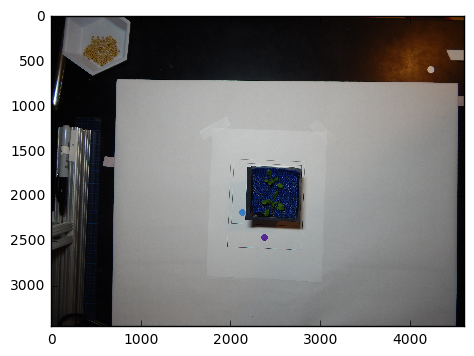

In [4]:
# STEP 3: Read RGB image and plot it to the notebook
# Inputs:
#    filename = name of image file
img, path, filename = pcv.readimage(rgb_img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

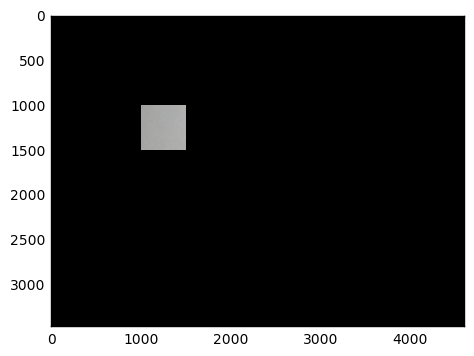

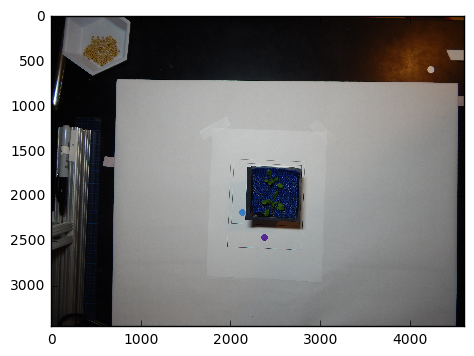

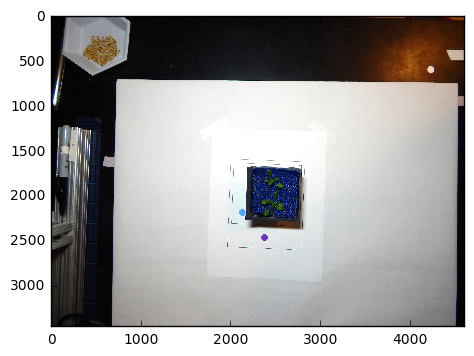

In [6]:
# Step 5: Normalize the white color so you can later
# compare color between images.
# Inputs:
# device = device number. Used to count steps in the workflow
# img = image object, RGB colorspace
# debug = None, print, or plot. Print = save to file, Plot = print to screen.
# roi = region for white reference, if none uses the whole image,
# otherwise (x position, y position, box width, box height)

#white balance image based on white toughspot
device,img1=pcv.white_balance(device,img,debug,roi=(1000,1000,500,500))

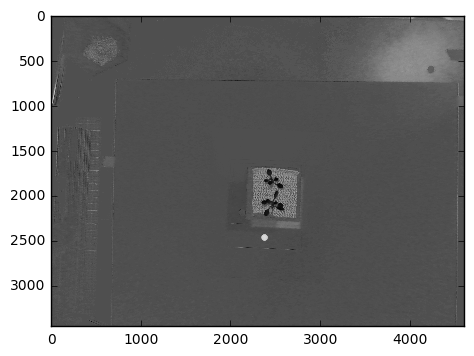

In [7]:
# STEP 7: Convert image from RGB colorspace to LAB colorspace
# Keep only the green-magenta channel (grayscale)
# Inputs:
#    img     = image object, RGB colorspace
#    channel = color subchannel (l = lightness, a = green-magenta , b = blue-yellow)
#    device  = device number. Used to count steps in the workflow
#    debug   = None, print, or plot. Print = save to file, Plot = print to screen.
device, a = pcv.rgb2gray_lab(img1, 'a', device, debug)

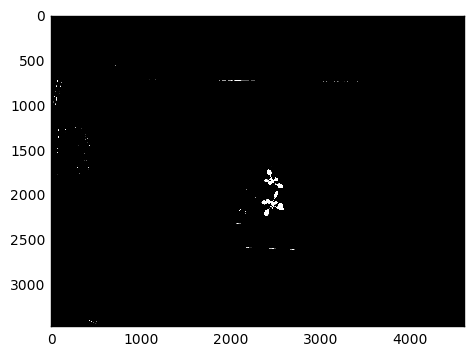

In [8]:
# STEP 8: Set a binary threshold on the Saturation channel image
# Inputs:
#    img         = img object, grayscale
#    threshold   = threshold value (0-255)
#    maxValue    = value to apply above threshold (usually 255 = white)
#    object_type = light or dark
#                  - If object is light then standard thresholding is done
#                  - If object is dark then inverse thresholding is done
#    device      = device number. Used to count steps in the pipeline
#    debug       = None, print, or plot. Print = save to file, Plot = print to screen.
device, img_binary = pcv.binary_threshold(a, 116, 255, 'dark', device, debug)
#                                            ^
#                                            |
#                                           adjust this value

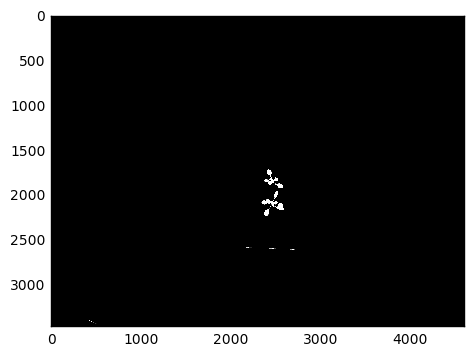

In [10]:
# STEP 9: Fill in small objects (speckles)
# Inputs:
#    img    = image object, grayscale. img will be returned after filling
#    mask   = image object, grayscale. This image will be used to identify contours
#    size   = minimum object area size in pixels (integer)
#    device = device number. Used to count steps in the pipeline
#    debug  = None, print, or plot. Print = save to file, Plot = print to screen.
mask = np.copy(img_binary)
device, fill_image = pcv.fill(img_binary, mask, 300, device, debug)
#                                               ^
#                                               |
#                                               adjust this value

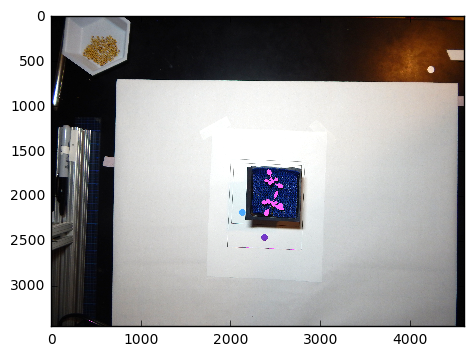

In [11]:
# STEP 11: Find objects (contours: black-white boundaries)
# Inputs:
#    img       = image that the objects will be overlayed
#    mask      = what is used for object detection
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
device, id_objects, obj_hierarchy = pcv.find_objects(img1, fill_image, device, debug)

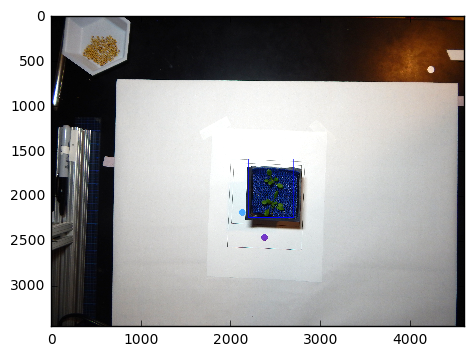

In [13]:
# STEP 12: Define region of interest (ROI)
# Inputs:
#    img       = img to overlay roi
#    roi       = default (None) or user input ROI image, object area should be white and background should be black,
#                has not been optimized for more than one ROI
#    roi_input = type of file roi_base is, either 'binary', 'rgb', or 'default' (no ROI inputted)
#    shape     = desired shape of final roi, either 'rectangle' or 'circle', if  user inputs rectangular roi but chooses
#                'circle' for shape then a circle is fitted around rectangular roi (and vice versa)
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
#    adjust    = either 'True' or 'False', if 'True' allows user to adjust ROI
#    x_adj     = adjust center along x axis
#    y_adj     = adjust center along y axis
#    w_adj     = adjust width
#    h_adj     = adjust height
device, roi, roi_hierarchy = pcv.define_roi(img1, 'rectangle', device, None, 'default', debug, True, 
                                             2200, 1600, -1900, -1200)
#                                            ^                ^
#                                            |________________|
#                                            adjust these four values

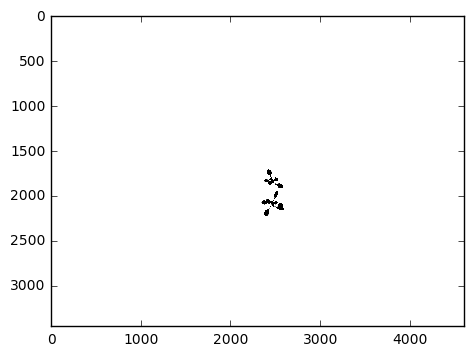

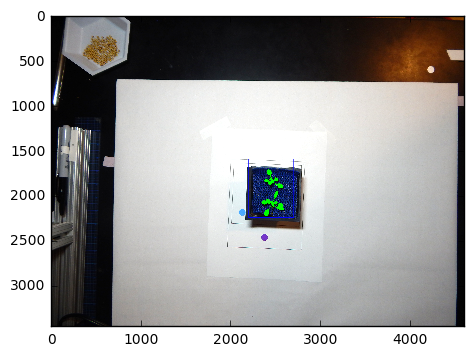

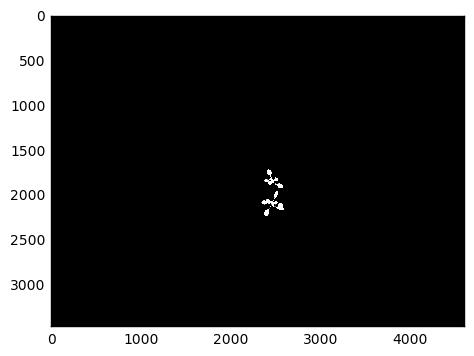

In [14]:
 # STEP 13: Keep objects that overlap with the ROI
# Inputs:
#    img            = img to display kept objects
#    roi_type       = 'cutto' or 'partial' (for partially inside)
#    roi_contour    = contour of roi, output from "View and Ajust ROI" function
#    roi_hierarchy  = contour of roi, output from "View and Ajust ROI" function
#    object_contour = contours of objects, output from "Identifying Objects" fuction
#    obj_hierarchy  = hierarchy of objects, output from "Identifying Objects" fuction
#    device         = device number.  Used to count steps in the pipeline
#    debug          = None, print, or plot. Print = save to file, Plot = print to screen.
device, roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img1, 'partial', roi, roi_hierarchy,
                                                                           id_objects, obj_hierarchy, device,
                                                                           debug)

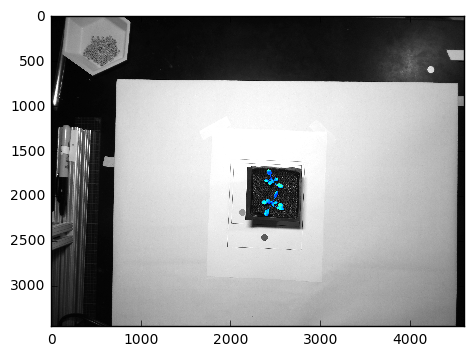

In [44]:
outfile='./'+str(filename[:-4])+'-outfile'

device, color_header,color_data,color_img= pcv.analyze_color(img1,img1,kept_mask, 256, device, debug,None,'v','img',300,outfile)

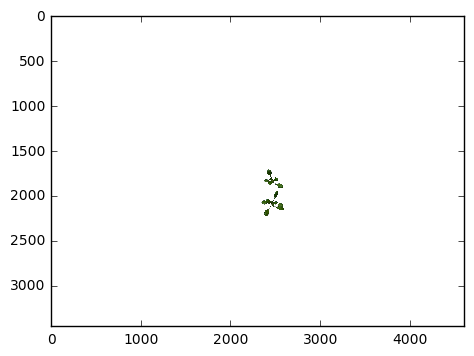

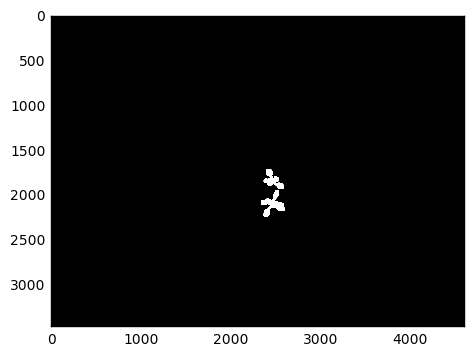

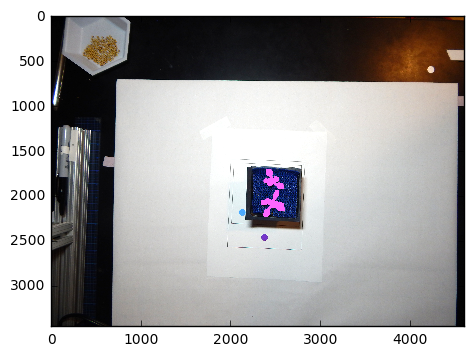

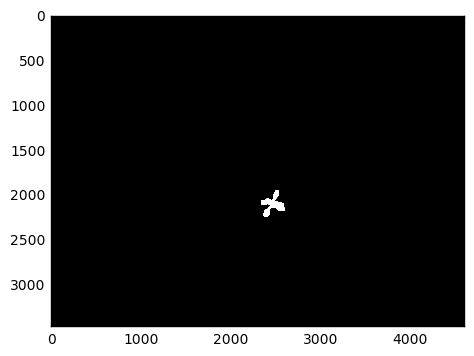

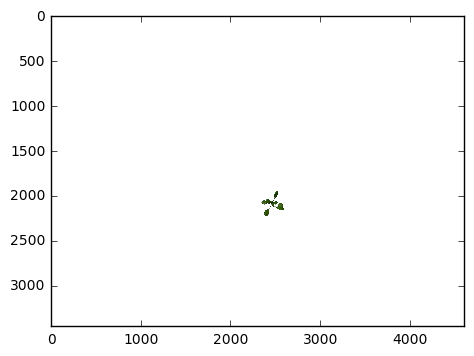

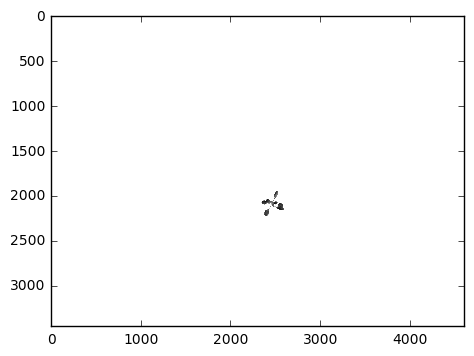

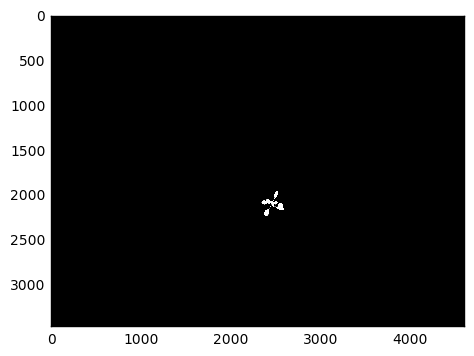

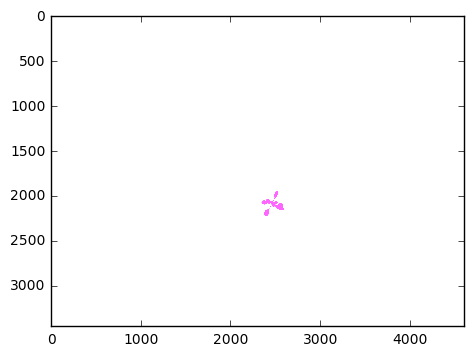

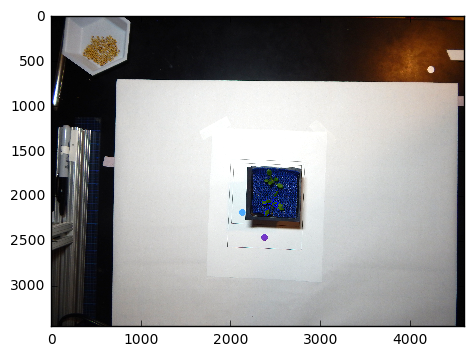

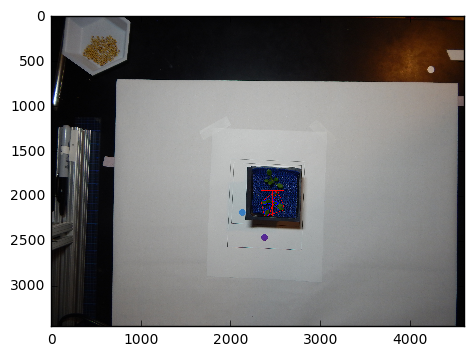

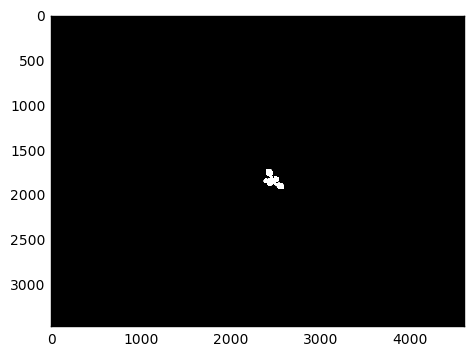

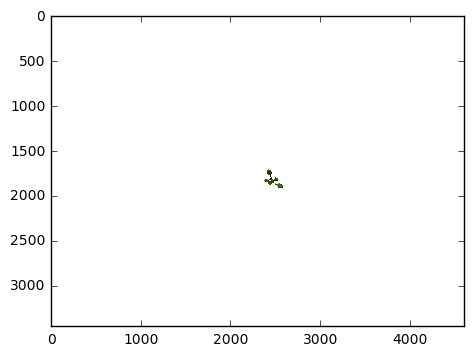

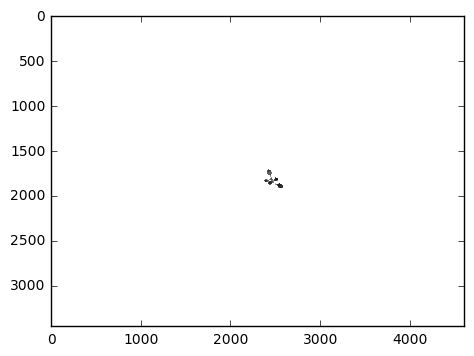

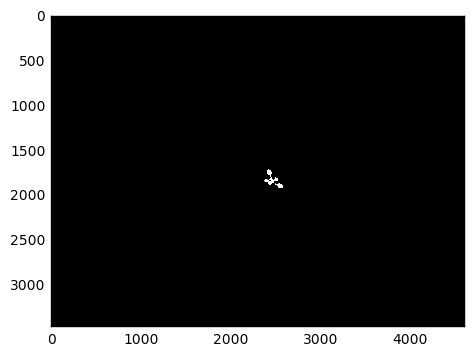

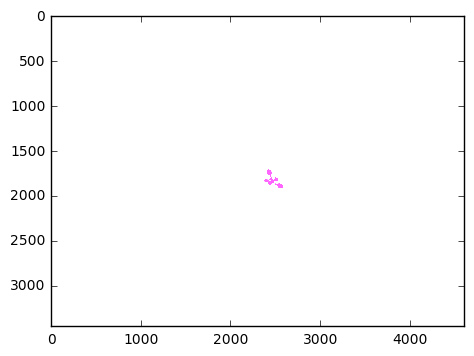

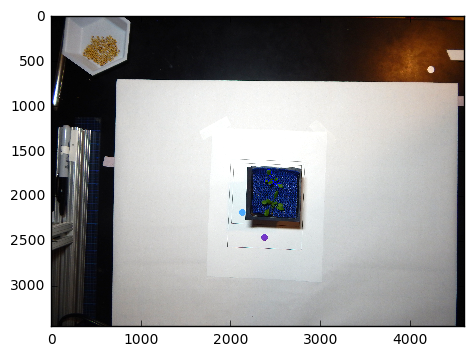

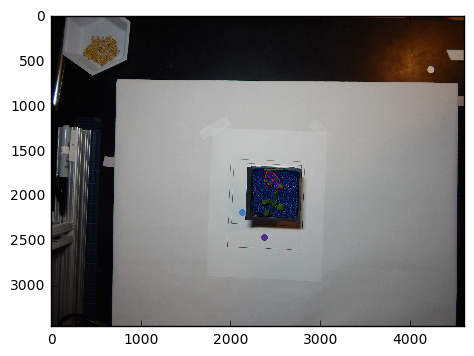

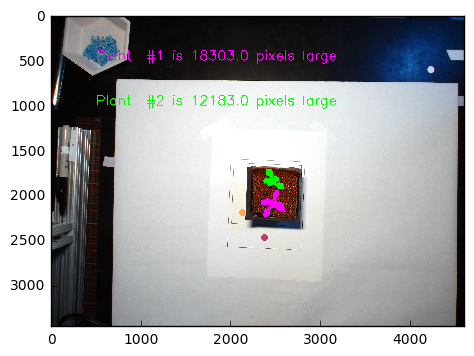

In [45]:
device,masked=pcv.apply_mask(img1,kept_mask,'white',device,debug)
device,dilated=pcv.dilate(kept_mask,10,2,device,debug)
device, plant_objects, plant_hierarchy = pcv.find_objects(img1, dilated, device, debug)

img_copy=np.copy(img1)

outfile='./'+str(filename[:-4])+'-outfile'
color=[(255,0,255),(0,255,0)]

for i in range(0, len(plant_objects)):
    background = np.zeros((np.shape(img1)),np.uint8)
    cv2.drawContours(background, plant_objects, i, (255,255,255), -1, lineType=8, hierarchy=plant_hierarchy)
    device,grayimg=pcv.rgb2gray(background,device,debug)
    device,masked1=pcv.apply_mask(masked,grayimg,'white',device,debug)
    device, a1 = pcv.rgb2gray_lab(masked1, 'a', device, debug)
    device, img_binary1 = pcv.binary_threshold(a1, 116, 255, 'dark', device, debug)
    device, single_object, single_hierarchy = pcv.find_objects(masked1, img_binary1, device, debug)
    device, obj, mask = pcv.object_composition(img1, single_object, single_hierarchy, 
                                           device, debug)
    device, shape_header, shape_data, shape_img = pcv.analyze_object(img, rgb_img, obj, mask, device, debug,outfile)
    cv2.drawContours(img_copy, plant_objects, i, color[i], -1, lineType=8, hierarchy=plant_hierarchy)
    plantsize="Plant  #"+str(i+1)+" is "+str(shape_data[1])+" pixels large"
    cv2.putText(img_copy, plantsize,(500,(i+1)*500), cv2.FONT_HERSHEY_SIMPLEX, 5,color[i],10)

pcv.print_image(img_copy,"arabidopsis-out_shapes.jpg")
plt.imshow(img_copy,cmap='gray')
plt.show()